In [23]:
import CoolProp 
from CoolProp.CoolProp import PropsSI
import pandas as pd
import numpy as np
import glob,sys,socket,fileinput
import os.path
import matplotlib.pyplot as plt
import scipy.signal as signal
import winsound

#FUNCION DETECTORA DE PICOS

def xlookup(lookup_value, lookup_array, return_array, if_not_found:str = ''):
    match_value = return_array.loc[lookup_array == lookup_value]
    if match_value.empty:
        return f'"{lookup_value}" not found!' if if_not_found == '' else if_not_found

    else:
        return match_value.tolist()[0]
    
    
#CARGA DE DATOS
D=50/1000 #Diametro de la parte cilindrica [m]
T=273.15+18
rho=PropsSI('D', 'T',T , 'P', 1e5, 'AIR') #Densidad del aire [kg/m3]
mu=PropsSI('V', 'T', T, 'P', 1e5, 'AIR') #Viscocidad del aire [Pa. s]
L=0.175*2 #Largo del cilindro en metros
A=D*L ## area proyectada

class medida:
    def __init__(self,direccion, espesor, largo):
        self.direccion = direccion
        self.espesor = espesor
        self.largo = largo
    
    def curva(self):
        a=str(str(self.direccion) + R"/e" + str(self.espesor) +R"/l"+str(self.largo))
        return a
    
#LECTURA DE DATOS
def analizadorCurva(carpeta):

    VelocityFile = "Velocidades Calibradas/Velocidades.txt"
    VelocityData = pd.read_csv(VelocityFile)
    PolinomioVelocidad=np.polyfit(VelocityData["V [V]"],VelocityData["U [m/s]"],1)

    RawDataFolder = str(carpeta)+"/"
    files = np.sort(glob.glob(RawDataFolder+'*.txt'))
    VoltajeMedicion=[]
    VelocidadMedicion=[]
    ReMedicion=[]
    for i in files:
        item=i[17:19]
        VoltajeMedicion.append(float(item))
        Vitem=PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
        VelocidadMedicion.append(Vitem)
        ReMedicion.append(Vitem*D*rho/mu)

    Inicial= {
        "Voltaje" : VoltajeMedicion,
        "Velocidad" : VelocidadMedicion,
        "Re" : ReMedicion,
        }

    DFInicial = pd.DataFrame(Inicial)


    DFFinal=pd.DataFrame()
    for k in files:
        #Importo los datos y le saco datos de cabeza y de cola
        datos = pd.read_csv(k, sep=",", header=None,skiprows=5)
        datos = datos[:-100]
        datos.columns = ["Time", "Frequency", "Drag", "Lift"]
        datos = datos.astype(float)
        datos=datos[800:2500]
        mediaLift=datos["Lift"].mean()
        stdLift=datos["Lift"].std()
        mediaDrag=(datos["Drag"].mean())
        stdDrag=(datos["Drag"].std())
        df=datos

        #Filtro para las cosas MUY gruesas por señales espurias, no se suele activar

        for i in df.index:
            #if df["Lift"][i]>(mediaLift+200*stdLift):
                #df["Lift"][i]=np.nan
            #if df["Lift"][i]<(mediaLift-200*stdLift):
                #df["Lift"][i]=np.nan
            if df["Drag"][i]>(mediaDrag+200*stdDrag):
                df["Drag"][i]=np.nan
            if df["Drag"][i]<(mediaDrag-200*stdDrag):
                df["Drag"][i]=np.nan
        mediaLift=datos["Lift"].mean()
        stdLift=datos["Lift"].std()
        mediaDrag=datos["Drag"].mean()
        stdDrag=datos["Drag"].std()   

        for i in df.index:
            #if df["Lift"][i]>(mediaLift+200*stdLift):
                #df["Lift"][i]=np.nan
            #if df["Lift"][i]<(mediaLift-200*stdLift):
                #df["Lift"][i]=np.nan
            if df["Drag"][i]>(mediaDrag+200*stdDrag):
                df["Drag"][i]=np.nan
            if df["Drag"][i]<(mediaDrag-200*stdDrag):
                df["Drag"][i]=np.nan
        mediaLift=datos["Lift"].mean()
        stdLift=datos["Lift"].std()
        mediaDrag=datos["Drag"].mean()
        stdDrag=datos["Drag"].std()

        df.interpolate(method ='linear', limit_direction ='backward', inplace=True)

        #LS para ver frecuencais
        tiempos=(df["Time"].values)/1000
        tiempos=tiempos-np.min(tiempos)
        fuerzas=df["Drag"].values
        fuerzas=fuerzas-np.mean(fuerzas)
        step=1/83.33
        w=np.linspace(1,2*np.pi*(1/step)*0.5,100000)
        pgram = signal.lombscargle(tiempos,fuerzas,w, normalize=True)

        dfLS=pd.DataFrame()
        dfLS["amp"]=pgram
        dfLS["frec"]=w/(2*np.pi)
        dfLS=dfLS.tail(82000)
        AmpDrag=(df["Drag"].max()-df["Drag"].min())/2
        frecpico=xlookup(dfLS["amp"].max(), dfLS["amp"], dfLS["frec"])


        vector = pd.DataFrame(np.array([[k],[mediaLift],[mediaDrag],[AmpDrag],[frecpico]]).T)
        DFFinal=pd.concat([DFFinal,vector], axis=0)

    DFFinal.rename(columns={0: 'txt', 1: 'MediaLift', 2: str("Media"+carpeta[0:4]), 3: str("Amp"+carpeta[0:4]), 4: str("Pico"+carpeta[0:4])}, inplace=True)
    DFFinal.reset_index(inplace=True)
    DatosCD=pd.concat([DFFinal,DFInicial],axis =1)
    
    if carpeta[0:4]=="Drag":
        RawDataFolder = "RefSoporteDrag/"
    if carpeta[0:4]=="Lift":
        RawDataFolder = "RefSoporteLift/"
        
    files = np.sort(glob.glob(RawDataFolder+'*.txt'))
    VoltajeMedicion=[]
    VelocidadMedicion=[]
    ReMedicion=[]
    vector=[]
    for i in files:
        item=i[16:18]
        VoltajeMedicion.append(float(item))
        Vitem=PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
        VelocidadMedicion.append(Vitem)
        ReMedicion.append(Vitem*D*rho/mu)

    Inicial= {
        "Voltaje" : VoltajeMedicion,
        "Velocidad" : VelocidadMedicion,
        "Re" : ReMedicion,
        }
    DFInicial2 = pd.DataFrame(Inicial)
    DFFinal2 = pd.DataFrame()

    for k in files:
        datos = pd.read_csv(k, sep=",", header=None,skiprows=5)
        datos = datos[:-100]
        datos.columns = ["Time2", "Frequency2", "Drag2", "Lift2"]
        datos = datos.astype(float)
        datos=datos[800:3000]
        mediaLift=datos["Lift2"].mean()
        stdLift=datos["Lift2"].std()
        mediaDrag=(datos["Drag2"].mean())
        stdDrag=(datos["Drag2"].std())
        df=datos

        for i in df.index:
            #if df["Lift2"][i]>(mediaLift+200*stdLift):
                #df["Lift2"][i]=np.nan
            #if df["Lift2"][i]<(mediaLift-200*stdLift):
                #df["Lift2"][i]=np.nan
            if df["Drag2"][i]>(mediaDrag+200*stdDrag):
                df["Drag2"][i]=np.nan
            if df["Drag2"][i]<(mediaDrag-4*stdDrag):
                df["Drag2"][i]=np.nan
        mediaLift=datos["Lift2"].mean()
        stdLift=datos["Lift2"].std()
        mediaDrag=datos["Drag2"].mean()
        stdDrag=datos["Drag2"].std()   

        for i in df.index:
            #if df["Lift2"][i]>(mediaLift+200*stdLift):
                #df["Lift2"][i]=np.nan
            #if df["Lift2"][i]<(mediaLift-200*stdLift):
                #df["Lift2"][i]=np.nan
            if df["Drag2"][i]>(mediaDrag+200*stdDrag):
                df["Drag2"][i]=np.nan
            if df["Drag2"][i]<(mediaDrag-200*stdDrag):
                df["Drag2"][i]=np.nan
        mediaLift=datos["Lift2"].mean()
        stdLift=datos["Lift2"].std()
        mediaDrag=datos["Drag2"].mean()
        stdDrag=datos["Drag2"].std()   


        vector = pd.DataFrame(np.array([[k],[mediaLift],[mediaDrag]]).T)
        DFFinal2=pd.concat([DFFinal2,vector], axis=0)


    DFFinal2.rename(columns={0: 'txt', 1: 'MediaLift', 2: str("Media"+carpeta[0:4])}, inplace=True)
    DFFinal2.reset_index(inplace=True)
    DatosCD=pd.concat([DFFinal2,DFInicial2],axis =1)
    
    
    
    ## Tomo la referencia y la borro del original

    DatosCD=pd.concat([DFFinal,DFInicial],axis =1)
    DatosCD2=pd.concat([DFFinal2,DFInicial2],axis =1)

    Referencia=DatosCD[:1]
    Drag0=Referencia["MediaDrag"][0]
    #Lift0=Referencia["MediaLift"][0]
    DatosCD=DatosCD.drop([0]) 


    Referencia2=DatosCD2[:1]
    Drag02=Referencia2["MediaDrag"][0]
    #Lift02=Referencia2["MediaLift"][0]
    DatosCD2=DatosCD2.drop([0]) 

    DatosCD["Drag"]= DatosCD["MediaDrag"].astype(float)-float(Drag0)
    #DatosCD["Lift"]= DatosCD["MediaLift"].astype(float)-float(Lift0)

    DatosCD2["Drag"]= DatosCD2["MediaDrag"].astype(float)-float(Drag02)
    #DatosCD2["Lift"]= DatosCD2["MediaLift"].astype(float)-float(Lift02)

    DatosCD["Drag"]= DatosCD["Drag"]-DatosCD2["Drag"]
    #DatosCD["Lift"]= DatosCD["Lift"]-DatosCD2["Lift"]
    DatosCD["St"]=D*DatosCD["PicoDrag"].astype(float)/DatosCD["Velocidad"].astype(float)
    DatosCD["AmpDrag"]=DatosCD["AmpDrag"].astype(float)*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])


    DatosCD=DatosCD.drop("txt", axis=1)
    DatosCD=DatosCD.drop("MediaDrag", axis=1)
    DatosCD=DatosCD.drop("MediaLift", axis=1)
    DatosCD=DatosCD.drop("index", axis=1)

    DatosCD[str("C"+carpeta[0])]=DatosCD["Drag"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])
    #DatosCD["CL"]=DatosCD["Lift"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])    
    
    
    
    
    
    
    
    
    return DatosCD
    

In [34]:
a=medida("Drag", "175", "0250")
b=medida("Drag", "175", "0375")
c=medida("Drag", "175", "0500")
d=medida("Drag", "175", "0625")
e=medida("Drag", "175", "0750")

In [35]:
c1=analizadorCurva(a.curva())
c2=analizadorCurva(b.curva())
c3=analizadorCurva(c.curva())
c4=analizadorCurva(d.curva())
c5=analizadorCurva(e.curva())

duration = 3000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

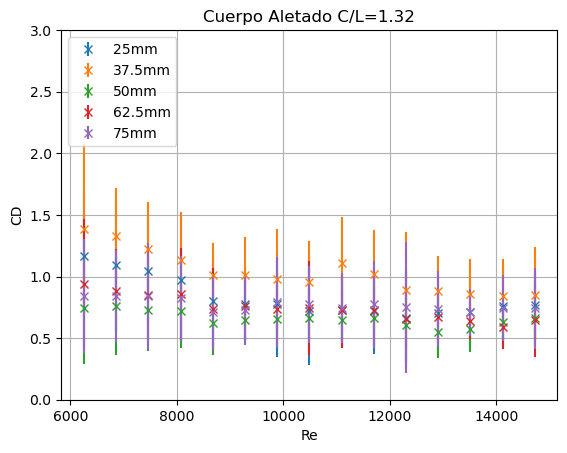

In [36]:
#tit="Cuerpo Aletado C/L=1.32"
#DatosCD.plot.scatter(x="Re", y="CD")
a=c1["Re"].values
b=c1["CD"].values
c=c1["St"].values


#plt.scatter(a, b, color="blue",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c1["AmpDrag"]).values, fmt="x",label="25mm")


a=c2["Re"].values
b=c2["CD"].values
c=c2["St"].values


#plt.scatter(a, b, color="red",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c2["AmpDrag"]).values, fmt="x",label="37.5mm")

a=c3["Re"].values
b=c3["CD"].values
c=c3["St"].values


#plt.scatter(a, b, color="yellow",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c3["AmpDrag"]).values, fmt="x",label="50mm")

a=c4["Re"].values
b=c4["CD"].values
c=c4["St"].values


#plt.scatter(a, b, color="green",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c4["AmpDrag"]).values, fmt="x",label="62.5mm")



a=c5["Re"].values
b=c5["CD"].values
c=c5["St"].values


plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=3)
plt.grid()

plt.errorbar(a, b, yerr=(c5["AmpDrag"]).values, fmt="x",label="75mm")


plt.legend(loc="upper left")



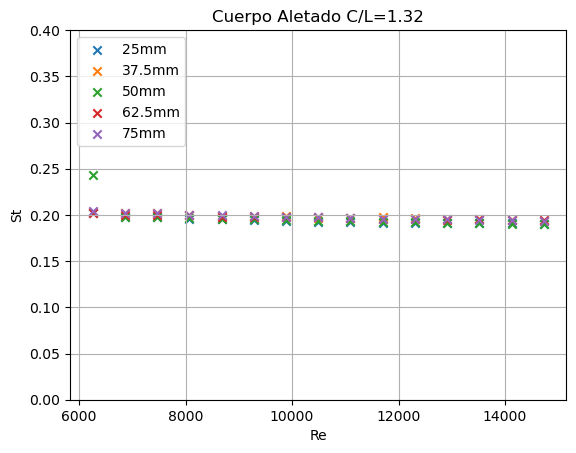

In [37]:
#tit="Cuerpo Aletado C/L=1.32"
#DatosCD.plot.scatter(x="Re", y="CD")
a=c1["Re"].values
b=c1["CD"].values
c=c1["St"].values


#plt.scatter(a, b, color="blue",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.scatter(a, c,label="25mm", marker="x")


a=c2["Re"].values
b=c2["CD"].values
c=c2["St"].values


#plt.scatter(a, b, color="red",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.scatter(a, c,label="37.5mm", marker="x")

a=c3["Re"].values
b=c3["CD"].values
c=c3["St"].values


#plt.scatter(a, b, color="yellow",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.scatter(a, c,label="50mm", marker="x")

a=c4["Re"].values
b=c4["CD"].values
c=c4["St"].values


#plt.scatter(a, b, color="green",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.scatter(a, c,label="62.5mm", marker="x")



a=c5["Re"].values
b=c5["CD"].values
c=c5["St"].values


plt.xlabel("Re")
plt.ylabel("St")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=0.4)
plt.grid()

plt.scatter(a, c,label="75mm", marker="x")


plt.legend(loc="upper left")